In [1]:
from gumbel_sigmoid_softmax import gumbel_softmax
import torch
import numpy as np

### Simple demo
* Sample from gumbel-softmax
* Average over samples

In [2]:
temperature = 0.01
logits = np.linspace(-2,2,10).reshape([1,-1])
logits = torch.Tensor(logits)
gumbel_sm = gumbel_softmax(logits, temperature=temperature)
sm = torch.softmax(logits, dim=1)

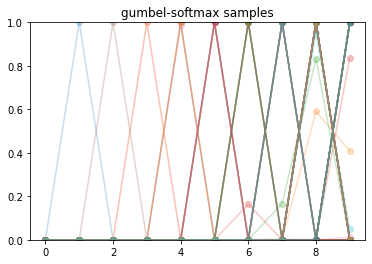

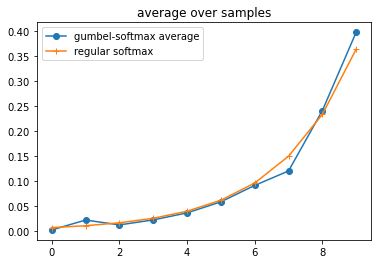

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('gumbel-softmax samples')
for i in range(100):
    plt.plot(range(10),gumbel_softmax(logits, temperature=temperature)[0],marker='o',alpha=0.25)
plt.ylim(0,1)
plt.show()

plt.title('average over samples')
samples = torch.stack(
    [gumbel_softmax(logits, temperature=temperature)[0] for _ in range(500)],
    dim=0
)
plt.plot(range(10), torch.mean(samples, axis=0),
         marker='o',label='gumbel-softmax average')

plt.plot(sm[0],marker='+',label='regular softmax')
plt.legend(loc='best')

# Autoencoder with gumbel-softmax

* We do not use any bayesian regularization, simply optimizer by backprop
* Hidden layer contains 32 units, split into 8 blocks of 4 variables
* Gumbel-softmax is computed over each block

In [4]:
from sklearn.datasets import load_digits
X = load_digits().data
print(X.shape)

(1797, 64)


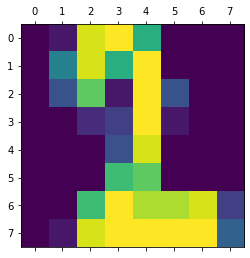

In [5]:
plt.matshow(X[1111].reshape(8,8))

In [6]:
# 设备配置
torch.cuda.set_device(0) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
import torch
from torch import nn


class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 32)  # #bottleneck
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 64)
        )
        self.tau = 1.0

    def set_temperature(self, tau):
        self.tau = tau
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)

    def reparameterization(self, x, hard=False):
        # #reshape so that softmax would be applied over blocks of 4
        return gumbel_softmax(x.view(-1,4), temperature=self.tau, hard=hard).view(-1,32)

    def forward(self, x, hard=False):
        x = self.encode(x)
        x = self.reparameterization(x, hard=hard)
        x = self.decode(x)
        return x

model = EncoderDecoder().to(device)
print(model)

EncoderDecoder(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
  )
)


## Training loop
* We gradually reduce temperature from 1 to 0.01 over time

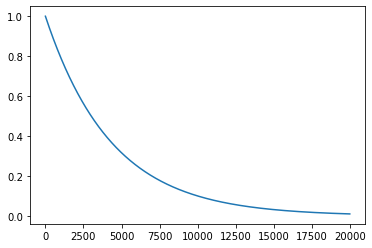

In [8]:
tau_values = np.logspace(0,-2,20000)
tau_values = np.clip(tau_values, 0.01, None)
plt.plot(tau_values)

In [9]:
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)

for i, t in enumerate(tau_values):
    batch = X[np.random.choice(len(X),32)]
    batch = torch.Tensor(batch).to(device)
    model.set_temperature(t)
    output = model(batch)
    loss = criteria(batch, output)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        with torch.no_grad():
            batch = X[np.random.choice(len(X), 320)]
            batch = torch.Tensor(batch).to(device)
            output = model(batch)
            loss = criteria(batch, output)
            print('%.3f' % loss, end='\t', flush=True)

60.489	22.065	18.951	18.810	18.605	18.591	18.668	18.617	18.990	18.997	19.197	18.737	18.676	18.659	18.570	18.967	18.594	18.685	19.111	19.017	18.826	18.917	18.490	18.816	18.344	17.868	17.412	17.135	16.636	16.374	16.408	15.801	15.249	14.973	14.332	14.588	13.561	13.437	12.906	13.309	12.409	12.483	11.780	11.457	11.114	11.342	10.841	10.601	10.773	10.788	10.615	9.948	9.941	10.228	10.065	9.814	9.875	9.639	9.472	9.559	9.321	9.730	9.168	8.749	9.053	9.623	8.865	8.830	8.958	8.843	8.498	8.685	8.518	8.323	8.679	8.855	8.392	8.075	8.243	8.075	8.376	8.460	8.252	8.323	8.397	7.871	8.073	8.016	8.223	8.219	8.022	7.726	7.995	7.958	7.610	7.927	8.033	8.126	8.326	8.013	7.874	8.060	8.033	8.234	7.554	7.837	8.152	7.966	7.647	7.604	7.883	7.641	7.568	7.607	7.721	7.396	7.671	7.670	7.741	7.555	7.405	7.832	7.663	7.436	7.841	7.939	7.398	7.148	7.616	7.414	7.481	7.272	7.638	7.248	7.618	7.571	7.642	7.345	7.129	7.624	7.627	7.317	7.721	7.402	7.237	7.836	7.567	7.696	7.649	7.230	7.164	7.442	7.289	7.159	7.279	7.514	7.782	7.524

In [10]:
#functions for visualization
get_sample = lambda x : model(x.to(device)).detach().cpu().numpy()
get_sample_hard = lambda x : model(x.to(device), hard=True).detach().cpu().numpy()
get_code = lambda x : model.reparameterization(model.encode(x.to(device))).detach().cpu().numpy()


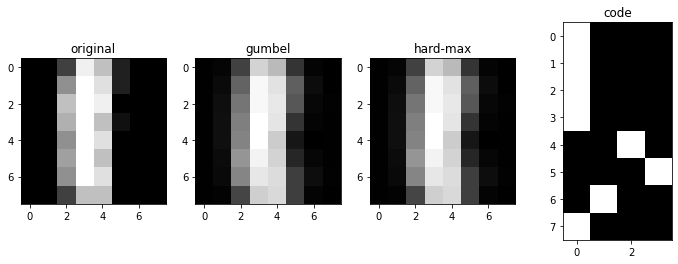

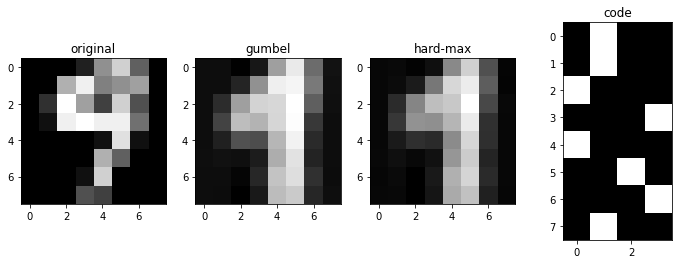

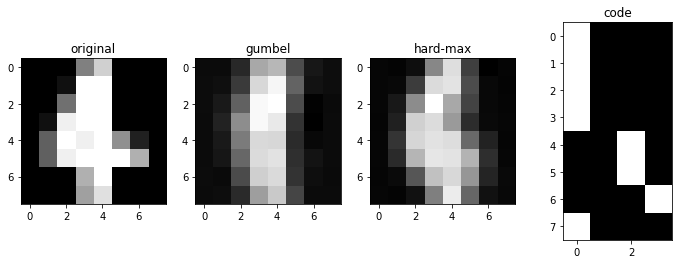

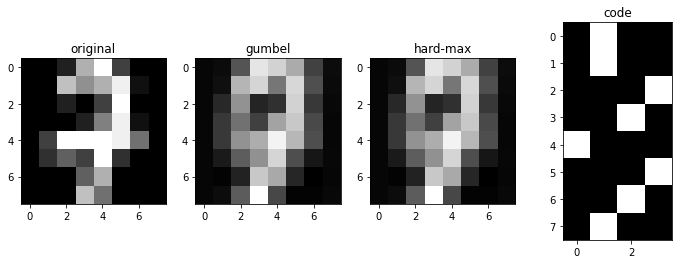

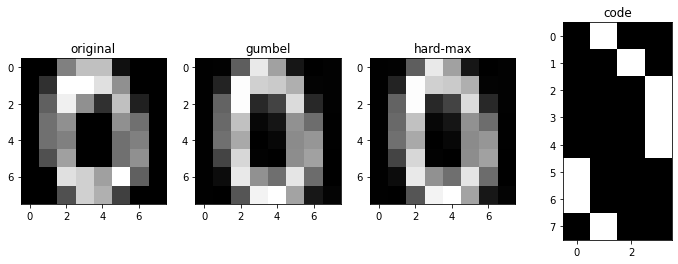

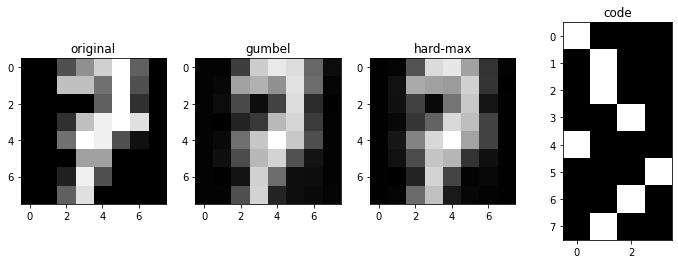

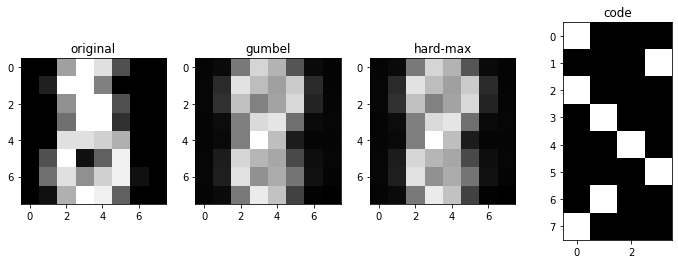

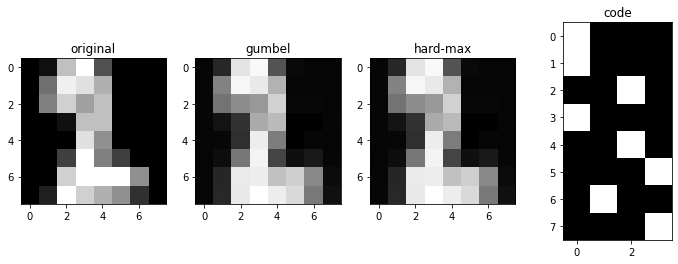

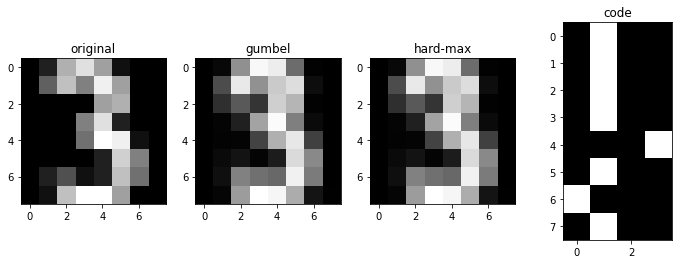

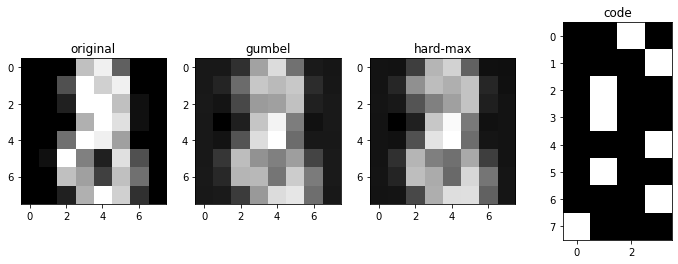

In [11]:
for i in range(10):
    X_sample = X[np.random.randint(len(X)),None,:]
    X_sample = torch.Tensor(X_sample).unsqueeze(0)
    plt.figure(figsize=[12,4])
    plt.subplot(1,4,1)
    plt.title("original")
    plt.imshow(X_sample.reshape([8,8]),interpolation='none',cmap='gray')
    plt.subplot(1,4,2)
    plt.title("gumbel")
    plt.imshow(get_sample(X_sample).reshape([8,8]),interpolation='none',cmap='gray')
    plt.subplot(1,4,3)
    plt.title("hard-max")
    plt.imshow(get_sample_hard(X_sample).reshape([8,8]),interpolation='none',cmap='gray')
    plt.subplot(1,4,4)
    plt.title("code")
    plt.imshow(get_code(X_sample).reshape(8,4),interpolation='none',cmap='gray')
    plt.show()